# Extract the PSF  some stars in HD163466 field
=====================================================================

- Creation : Friday 2016 June 24th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

PSF of HD163466 without grating


## 1) Import package

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [24]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [25]:
#photutils.test()

In [26]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [27]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [28]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-27 10:12:24.878051
fits date format for the analysis :  2016-06-27T10:12:24


## 3) Configuration of the input file

- HD158485_grat_science.fits
- HD159222_grat_science.fits
- HD163466_grat_science.fits


In [29]:
#object_name='HD158485_grat_20'
#object_name='HD159222_grat'
object_name='HD163466_none'

In [30]:
path='./HD163466_none'
basefilename='AssScImHD163466_none_1.fits' # check master bias
filename=os.path.join(path,basefilename)

## 4) Read the images

In [31]:
allimages = []
ccd_chan = ccdproc.CCDData.read(filename, hdu=0,unit='adu') 
allimages.append(ccd_chan)

data=ccd_chan.data

## 5) Shows the images

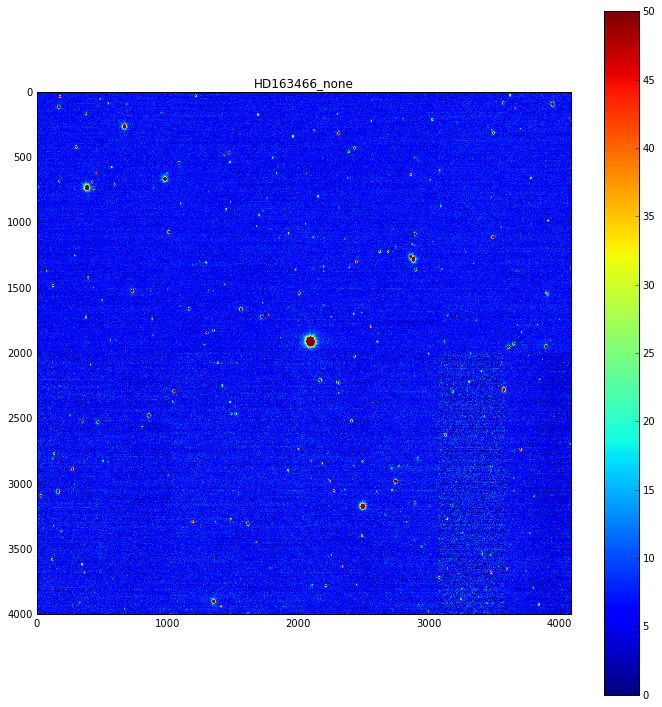

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
img=ax.imshow(ccd_chan,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
#plt.savefig(outputfigfilename3)

# 6) Subtract background

code implemented from photutil information there:
https://photutils.readthedocs.io/en/latest/photutils/background.html#

In [54]:
from photutils.background import Background2D
bkg = Background2D(data, (100, 100), filter_size=(3, 3),method='median')

### does the background varies over the field of view ?

In [55]:
print('median background = ',bkg.background_median)
print('median rms = ',bkg.background_rms_median)

('median background = ', 6.2056447331499047)
('median rms = ', 2.3908852533343983)


### Radiography of the background

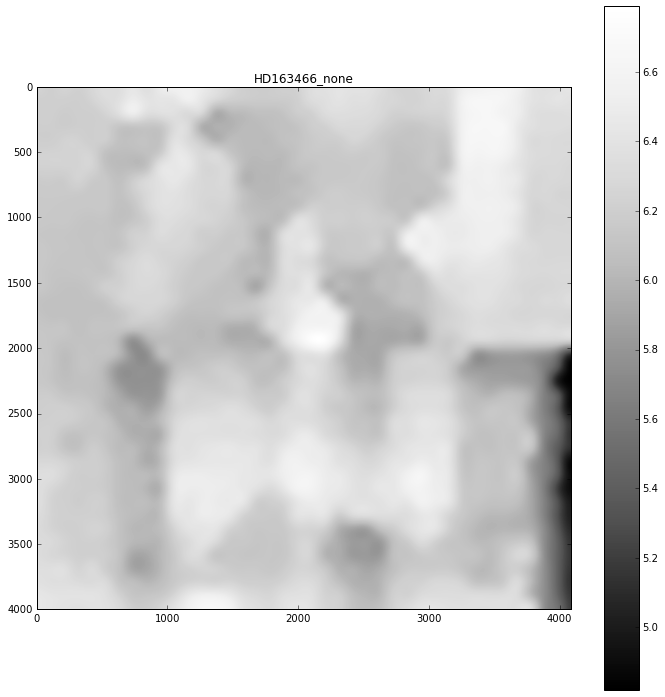

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=ax.imshow(bkg.background, cmap='Greys_r')
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

### Now subtract the background

In [51]:
data2=data - bkg.background

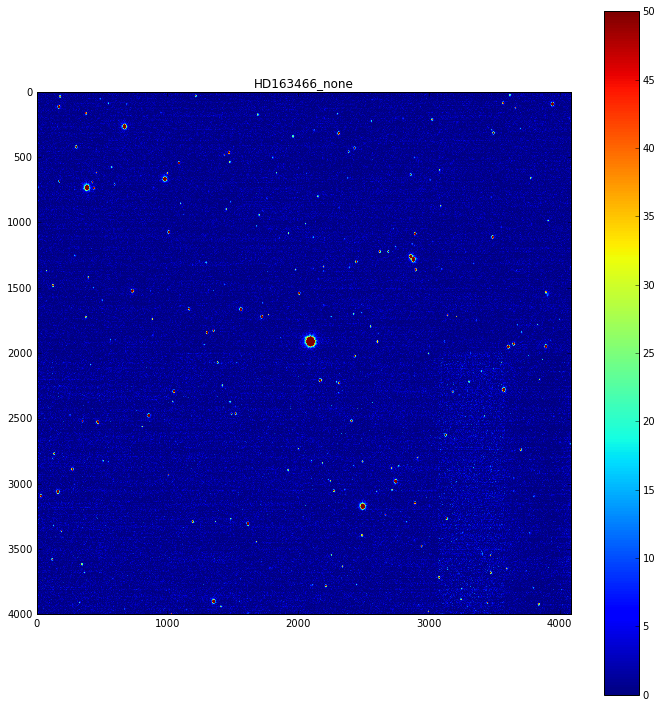

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(data2, vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

## 8.) Compute signal and noise

In [116]:
mean, median, std = sigma_clipped_stats(data2, sigma=10.0, iters=5)    
print(mean, median, std)    

(0.062176506159892835, 0.016082801307462091, 2.6423250490042354)


In [223]:
sources = daofind(data2 - median, fwhm=3.0, threshold=50.*std)
sources.sort('flux')
print(sources)   

 id   xcentroid     ycentroid   ...      flux            mag       
--- ------------- ------------- ... ------------- -----------------
  5 1466.05904306  467.04116243 ...  1.0033369043 -0.00361696642902
 12 2878.19742899 1294.79501258 ... 1.07151739585  -0.0749980652803
 18 1299.98881688 1844.17361315 ... 1.08526917064  -0.0888436653381
  6 3928.01411513 587.601731815 ...  1.0957241039  -0.0992530385737
  4 299.930943701 423.593310587 ... 1.10473846432   -0.108148688384
 41 1609.54841106 3301.34035934 ... 1.12360159724    -0.12653086974
 26 3640.98950965 1929.56594759 ... 1.14499359642   -0.147007644536
 38 30.6214711597 3092.97919732 ... 1.22692582472   -0.222045769308
 14 2003.26383449   1542.861437 ... 1.28837813267    -0.27510836259
 33 461.845533843  2526.3984714 ... 1.52067215186   -0.455088981905
...           ...           ... ...           ...               ...
 24 2095.33735749 1923.81444652 ... 14.4218133816    -2.89754967871
  7 977.018930637 670.009500526 ... 15.674447759

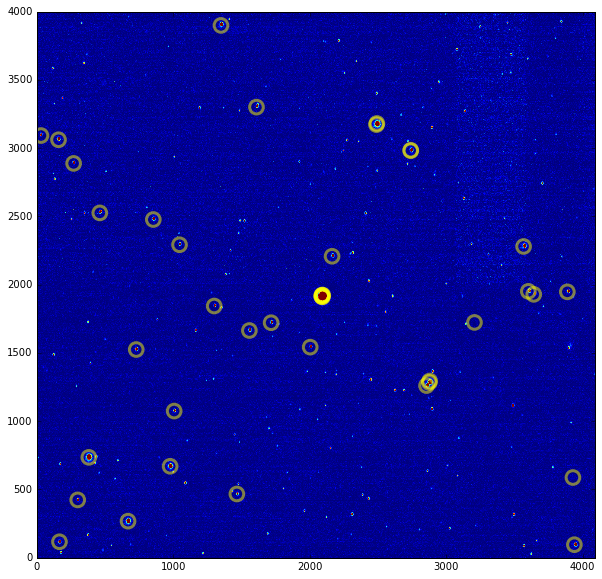

In [224]:
fig, ax = plt.subplots(figsize=(10, 10))
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=50.)
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(data2,vmin=0,vmax=50.,origin='lower')
#ax.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='yellow', lw=3., alpha=0.5)

In [225]:
NBSTARS=25
XX=np.zeros(NBSTARS)
YY=np.zeros(NBSTARS)
selected_stars=sources.as_array()
for istar in range(NBSTARS):
    XX[istar] = int(selected_stars[istar][1])
    YY[istar] = int(selected_stars[istar][2])
    
    print XX[istar],YY[istar]

1466.0 467.0
2878.0 1294.0
1299.0 1844.0
3928.0 587.0
299.0 423.0
1609.0 3301.0
3640.0 1929.0
30.0 3092.0
2003.0 1542.0
461.0 2526.0
3887.0 1947.0
1006.0 1074.0
1716.0 1721.0
270.0 2888.0
1045.0 2292.0
2739.0 2985.0
3601.0 1951.0
2163.0 2208.0
166.0 116.0
1557.0 1664.0
728.0 1525.0
853.0 2477.0
3206.0 1723.0
2491.0 3181.0
3938.0 95.0


In [234]:
# Extract the plot of a PSF
index=8

psf=data2[YY[index]-10:YY[index]+10,XX[index]-10:XX[index]+10]

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


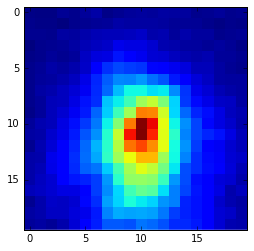

In [237]:
plt.imshow(psf,interpolation='None')

### Estimation of PRF (PSF)


I could not use any of the utilities function.
It lacks of working examples

In [66]:
import photutils.psf 
from photutils.psf import psf_photometry

In [67]:
from astropy.modeling import models, fitting

In [68]:
import photutils
from photutils import psf

photutils.__version__

u'0.3.dev1833'

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


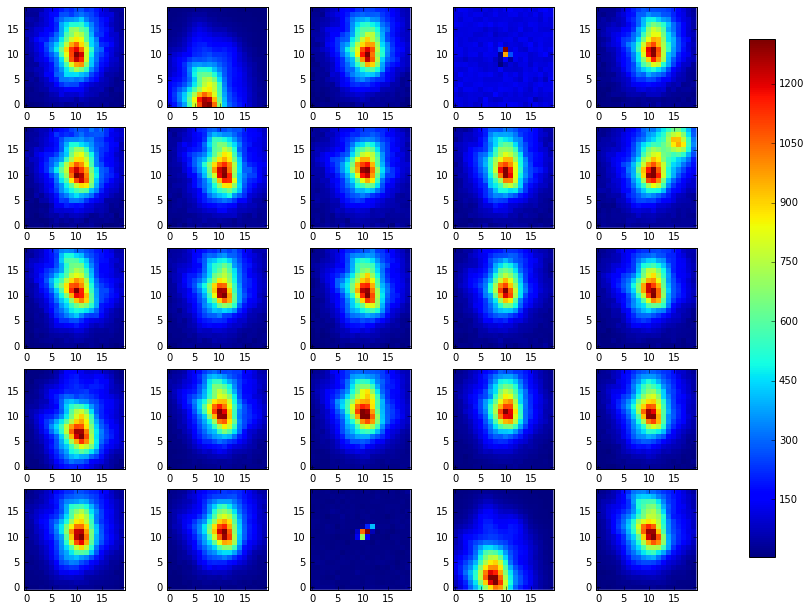

In [228]:
fig, axes = plt.subplots(nrows=5, ncols=5)
fig.set_size_inches(12, 9)
# Plot kernels
for i in range(5):
    for j in range(5):
        index=5*i+j
        if index <NBSTARS :
            prf_image = data2[YY[index]-10:YY[index]+10,XX[index]-10:XX[index]+10]
            im = axes[i, j].imshow(prf_image, interpolation='None',origin='lower')
			
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(im, cax=cax)
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)
plt.show()

In [201]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

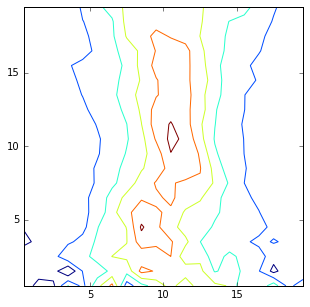

In [232]:
plt.figure(figsize=(5,5))
psf2 = psf / np.linalg.norm(psf, axis=-1)[:, np.newaxis]
plt.contour(psf2,origin='lower')

In [259]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [262]:
XV=np.arange(20)-10
YV=np.arange(20)-10
X3,Y3=np.meshgrid(XV,YV)

In [263]:
Y3.shape

(20, 20)

In [264]:
psf2.shape

(20, 20)

In [265]:
weighted_avg_and_std(X3,psf2)

(-0.10275862640265693, 3.6990751240080897)

In [266]:
weighted_avg_and_std(Y3,psf2)

(-0.47330375719768902, 5.8674145301855685)

In [269]:
3.7*0.4

1.4800000000000002